In [6]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring
from gerkin import dream,params
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load the data
descriptors = loading.get_descriptors(format='True')
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
#mdx_full = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
mdx_drag_morg = dream.get_molecular_data(['dragon','morgan'],all_CIDs)

Morgan has 2437 features for 476 molecules.
There are now 7307 total features.


In [5]:
# Create the feature and descriptor arrays 
sets = ['training','leaderboard']
X_drag_morg,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,sets)
X_drag_morg_sq = dream.quad_prep(mdx_drag_morg,sets=sets)
Y_all,imputer = dream.make_Y_obs(sets,target_dilution=None,imputer='mask')

The X matrix now has shape (814x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x14614) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Load or compute the random forest model

In [10]:
# Load or compute the random forest model correlations (obtained from cross-validation)
use_saved_rf_model = True
n_splits = 100
n_features = [1,2,3,4,5,10,33,100,333,1000,3333,10000]
if use_saved_rf_model:
    rs0 = np.load('../../data/forest_rs_250_0.npy')
    rs0_9 = np.load('../../data/forest_rs_250_0-9.npy')
    rs10_20 = np.load('../../data/forest_rs_250_10-20.npy')
    rs_forest = rs0_9.copy()
    rs_forest[0,:,:] = rs0[0,:,:]
    rs_forest[10:,:,:] = rs10_20[10:,:,:]
    rs_forest = np.ma.array(rs_forest,mask=np.isnan(rs_forest))
else:
    trans_params = params.get_trans_params(Y_all, descriptors, plot=False)
    use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()
    rs_forest = feature_sweep(X_drag_morg[:,:-1],Y,n_estimators=50,n_splits=n_splits,n_features=n_features,model='rf',
                              rfe=False,max_features=max_features,max_depth=max_depth,min_samples_leaf=min_samples_leaf)
    np.save('../../data/rs_forest_%d',rs_forest)

### Load or compute the linear model

In [11]:
# Load or compute the feature ranks for the training set
use_saved_linear_feature_ranks = True
if use_saved_linear_feature_ranks:
    lin_ranked = np.load('../../data/lin_ranked_rick.npy')
else:
    # -1 is to leave out the leak feature
    lin_ranked = fit1.compute_linear_feature_ranks_cv(X_train_lin[:,:-1],Y_all['mean_std'],
                                                      n_resampling=10,n_splits=n_splits)
    np.save('../../data/lin_ranked_rick',lin_ranked)

In [12]:
use_saved_lin_model = True
if use_saved_lin_model:
    rs_lin = np.load('../../data/rs_lin_rick_right.npy')
    rs_lin = np.ma.array(rs_lin,mask=np.isnan(rs_lin))
else:
    rs_lin = feature_sweep(X_drag_morg_sq[:,:-1],Y,n_splits=n_splits,model='lin',rfe=False,
                           alpha=10.0,lin_ranked=lin_ranked)
    np.save('../../data/rs_forest_%d',rs_forest)

## Figure 3C

In [18]:
# Plotting function
def plot(forest,lin,labels=['forest','quadratic']):
    fig,axes = plt.subplots(3,7,sharex=False,sharey=True,figsize=(20,10))
    for col,ax in enumerate(axes.flat):
        ax.errorbar(n_features,forest[col,:,:].mean(axis=1),forest[col,:,:].std(axis=1)/np.sqrt(n_splits),color='red',label=labels[0])
        ax.errorbar(n_features,lin[col,:,:].mean(axis=1),lin[col,:,:].std(axis=1)/np.sqrt(n_splits),color='blue',label=labels[1])
        if col==0:
            handles, labels = ax.get_legend_handles_labels()
            lg = ax.legend(handles[0:], labels[0:], loc=4, fontsize=16)
            lg.draw_frame(False)

        ax.set_xlim(0.5,20000)
        ax.set_ylim(0,0.8)
        ax.set_yticks(np.linspace(0,0.6,4))
        ax.set_yticklabels([_ for _ in np.linspace(0,0.6,4)],size=20)
        ax.set_xticklabels(n_features,size=20)
        ax.set_xscale('log')
        ax.set_title(descriptors[col], size=25)
    plt.tight_layout()
    fig.text(0.5, -0.025, 'Number of features', ha='center', size=25)
    fig.text(-0.02, 0.5, 'Correlation', va='center', rotation='vertical', size=25);

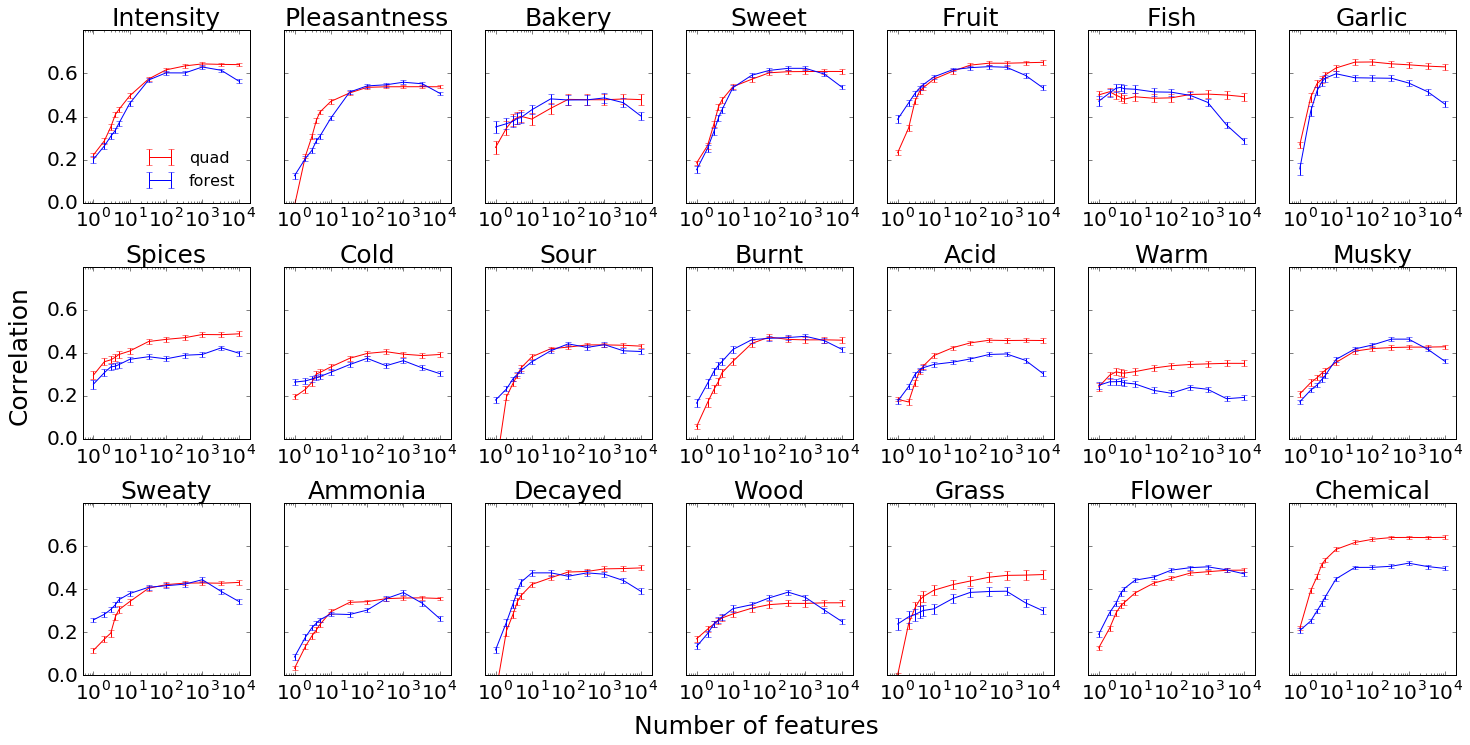

In [20]:
plot(rs_forest[:,:,:n_splits],rs_lin[:,:,:n_splits],labels=['quad','forest'])
plt.savefig('../../figures/quad_forest_vs_features.eps',format='eps')